<a href="https://www.kaggle.com/code/karimtarek04/egypt-house-prices-predictor-accuray-67?scriptVersionId=138465754" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
# Basic python libraries import (to handle visualizations and dataframes)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid",font_scale=1.5)
pd.set_option("display.max.columns",None)
# Transformations imports 
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
# Machine learning models imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
# Data pre-processing 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
# Pre-processing
from sklearn import preprocessing


# Math 
import math


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading The Data

In [2]:
df_main = pd.read_csv("/kaggle/input/egypt-housing-prices/properties.csv")
df_main.head()

,type,title,location,bedroom,bathroom,size_sqm,price
0,Duplex,Prime Location Duplex Fully Finished With A\C,"Park View, North Investors Area, New Cairo Cit...",4,4,345,"6,850,000"
1,Villa,Town house resale at Mivida Emaar with best price,"Mivida, 5th Settlement Compounds, The 5th Sett...",3,3,285,"10,000,000"
2,Apartment,Lake View Residence - Apartment | Prime Location,"Lake View Residence, 5th Settlement Compounds,...",3,3,210,"5,700,000"
3,Townhouse,Best Penthouse for sale in villette ( sky conds ),"La Vista City, New Capital Compounds, New Capi...",4,4,230,"7,510,000"
4,Penthouse,2nd Floor | Fully Finished | Lowest Price |Par...,"Villette, 5th Settlement Compounds, The 5th Se...",5,6,284,"8,511,300"


# Hypothesis Statement

**Our victory goal here is to build a machine learning model that can predict prices accuratly if given the right inputs.**
But before that we go through exploratory data analysis to figure the distribution and coerelation of the attributes, then pre-process them to be fed into the machine learning model(s). we check the accuracy of different models and pick the one that gives us the best accuracy.

# Data Wrangling (Cleaning)

In [3]:
df_main.info()
df_main.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11418 entries, 0 to 11417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   type      11418 non-null  object
 1   title     11418 non-null  object
 2   location  11418 non-null  object
 3   bedroom   11418 non-null  object
 4   bathroom  11418 non-null  int64 
 5   size_sqm  11418 non-null  object
 6   price     11418 non-null  object
dtypes: int64(1), object(6)
memory usage: 624.5+ KB


,type,title,location,bedroom,bathroom,size_sqm,price
0,Duplex,Prime Location Duplex Fully Finished With A\C,"Park View, North Investors Area, New Cairo Cit...",4,4,345,"6,850,000"
1,Villa,Town house resale at Mivida Emaar with best price,"Mivida, 5th Settlement Compounds, The 5th Sett...",3,3,285,"10,000,000"
2,Apartment,Lake View Residence - Apartment | Prime Location,"Lake View Residence, 5th Settlement Compounds,...",3,3,210,"5,700,000"
3,Townhouse,Best Penthouse for sale in villette ( sky conds ),"La Vista City, New Capital Compounds, New Capi...",4,4,230,"7,510,000"
4,Penthouse,2nd Floor | Fully Finished | Lowest Price |Par...,"Villette, 5th Settlement Compounds, The 5th Se...",5,6,284,"8,511,300"


* seems we'd need to firstly remove delimiter "," from both "size_sqm" and "price" attributes
* then convert ("bedroom","size_sqm","price") to numerical columns 

### Check Nulls

In [4]:
null_array = round(df_main.isnull().sum()/len(df_main)*100,2).sort_values().to_frame().rename(columns= {0:"Train % of Missing Values"})
print(null_array, end='\n')

          Train % of Missing Values
type                            0.0
title                           0.0
location                        0.0
bedroom                         0.0
bathroom                        0.0
size_sqm                        0.0
price                           0.0


NO NULLS

### Check unique values

In [5]:
for column in df_main.columns:
    print(f"Value counts for column '{column}':", end='/n')
    print(df_main[column].value_counts())
    print("\n----------------------\n")

Value counts for column 'type':/nApartment          5848
Villa              2845
Townhouse           858
Twin House          601
Duplex              568
Penthouse           448
iVilla              199
Hotel Apartment      34
Chalet               14
Compound              3
Name: type, dtype: int64

----------------------

Value counts for column 'title':/nVilla for sale In Lake View L:600 BUE:550 price18M                 14
STANDALONE in Palm Hills Katameya EX.PK2 For Sale                  13
2 bedrooms|2 bath|Terrace|with disc                                13
3 bedrooms|7 years install|Ready to move|Disc 12%                  12
Move Now to Standalone Villa with 5% DP over 8 years Sodic East     9
                                                                   ..
Pay Only 5% DP | Over 9 Years by Tatweer Misr                       1
Apartment 88 m fully finished without over loading                  1
Penthouse In Katameya Plaza Sodic Fully Finished                    1
Penthouse for

* remove columns with price value "ask"

* remove columns with bedroom value {0}

* trasform bedroom value "Studio" => 1 

* remove delimiter "," from "price, size_sqm" columns

* lowercase "title" & "location" columns

* extract city from location (then drop location) 

* convert "price, size_sqm & bedroom to integer values 

* group similar cities (subject of matter experts) 
* combine villa & ivilla in type column 
* note: obvious outliers in size_sqm (having count of 1)

In [6]:
df_wrangled = df_main.copy()

# Lowercase all string based columns 
for column in ['title','location','type']:
    df_wrangled[column] = df_wrangled[column].apply(lambda m: m.lower())
    
# remove columns with price value "ask"
df_wrangled = df_wrangled[df_wrangled['price'] != 'Ask']

# remove columns with bedroom value {0}
df_wrangled = df_wrangled[df_wrangled['bedroom'] != '{0}']

# trasform bedroom value "Studio" => 1 
df_wrangled['bedroom'].replace('Studio', 1)

# transform type 
df_wrangled.type=df_wrangled.type.apply(lambda m:m.replace('ivilla','villa'))
df_wrangled.type=df_wrangled.type.apply(lambda m:m.replace('compound','apartment'))
df_wrangled.type=df_wrangled.type.apply(lambda m:m.replace('hotel apartment','apartment'))

# remove delimiter "," from "price, size, square km columns "
df_wrangled.price=df_wrangled.price.apply(lambda m:m.replace(',',''))
df_wrangled.size_sqm =df_wrangled.size_sqm.apply(lambda m:m.replace(',',''))


# Convert [price, size_sqm & bedroom] to numeric
for column in ['price','size_sqm','bedroom']:
    df_wrangled[column] = df_wrangled[column].apply(pd.to_numeric, errors='coerce').round(0)

# Validate casting
df_wrangled.info()

# Validate
for column in ['price','bedroom']:
    print(f"Value counts for column '{column}':", end='/n')
    print(df_wrangled[column].value_counts())
    print("\n----------------------\n")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11005 entries, 0 to 11417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   type      11005 non-null  object 
 1   title     11005 non-null  object 
 2   location  11005 non-null  object 
 3   bedroom   10969 non-null  float64
 4   bathroom  11005 non-null  int64  
 5   size_sqm  11005 non-null  int64  
 6   price     11005 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 687.8+ KB
Value counts for column 'price':/n2500000    174
3000000    168
3500000    154
4000000    131
2000000    128
          ... 
3999138      1
6180000      1
2555559      1
2270750      1
4554066      1
Name: price, Length: 2496, dtype: int64

----------------------

Value counts for column 'bedroom':/n3.0    5443
4.0    2372
2.0    1426
5.0     961
6.0     360
8.0     177
1.0     137
7.0      93
Name: bedroom, dtype: int64

----------------------



### Grouping similar cities
* From public knoweldge, it seems some cities can be grouped into a single parent city, subsequently we create a new column "parent city".
* note: the below city mapping was extracted from another project and used to reduce number of cities.

In [7]:
# Assuming you have a DataFrame named df_wrangled

# Mapping dictionary
city_mapping = {
    '5th': 'New Cairo', 'settlement': 'New Cairo', 'tag sultan': 'New Cairo',
    'mivida': 'New Cairo', 'new capital': 'New Capital', 'capital': 'New Capital',
    'mostakbal': 'Mostakbal City', 'madinaty': 'Shorouk', 'eastown': 'Shorouk',
    'heliopolis': 'New Heliopolis', 'uptown': 'Cairo', 'zamalek': 'Cairo',
    'mokattam': 'Cairo', 'maadi': 'Cairo', 'nasr': 'Cairo'
}

# Apply the mapping to both 'title' and 'location' columns to create the 'city_parent' column
df_wrangled['city_parent'] = df_wrangled['title'].str.lower().fillna('').apply(lambda x: next((city_mapping[k] for k in city_mapping if k in x), 'Cairo'))

# Update the 'city_parent' column based on the 'location' column
mask = df_wrangled['city_parent'] == 'Cairo'
df_wrangled.loc[mask, 'city_parent'] = df_wrangled.loc[mask, 'location'].str.lower().fillna('').apply(lambda x: next((city_mapping[k] for k in city_mapping if k in x), 'Cairo'))

# Fill any remaining 'NA' values in the 'city_parent' column with 'Cairo'
df_wrangled['city_parent'].fillna('Cairo', inplace=True)

# Validate the 'city_parent' column
print(f"Value counts for column 'city_parent':")
print(df_wrangled['city_parent'].value_counts())

Value counts for column 'city_parent':
New Cairo         5273
Cairo             3091
Shorouk            949
New Capital        923
Mostakbal City     430
New Heliopolis     339
Name: city_parent, dtype: int64


### Removing Outliers (Non-target attributes: "Size_Sqm") 


----------------------

Skewness for column 'bedroom': 1.3478659600419531
Skewness for column 'bathroom': 1.0929951684977177
Skewness for column 'size_sqm': 46.18177339410496
Skewness for column 'price': 11.008690694223787

----------------------



26650000    1
24500000    1
15500000    1
14500000    1
14350000    1
           ..
43          1
36          1
35          2
34          1
1           1
Name: size_sqm, Length: 708, dtype: int64

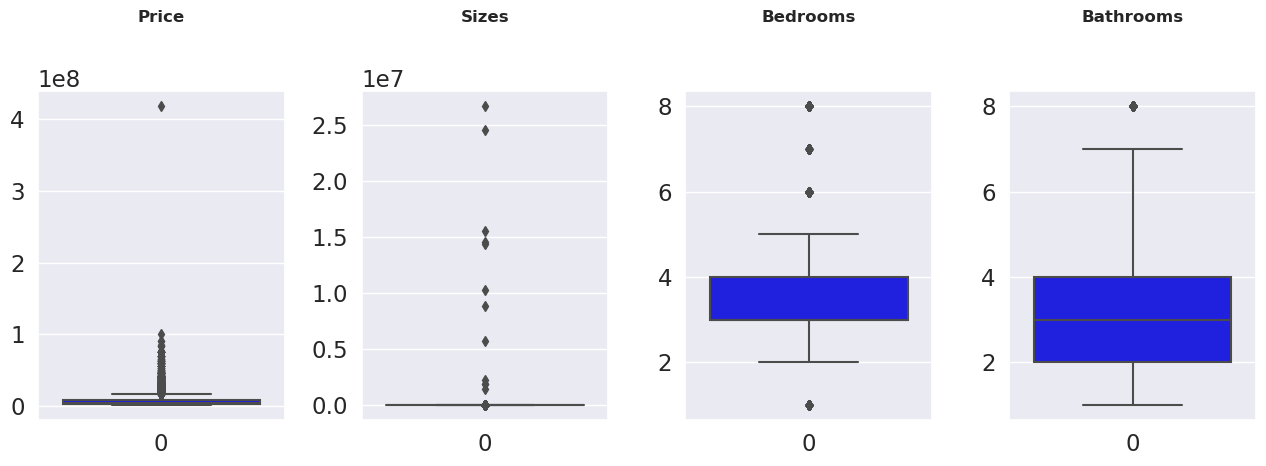

In [8]:
# Plot outliers 
plt.figure(figsize=(13,5))

# Price outliers 
plt.subplot(1,4,1)
sns.boxplot(df_wrangled["price"],color="blue")
plt.title("Price" ,fontweight="black",pad=50,size=12)
plt.tight_layout()

# Size outliers 
plt.subplot(1,4,2)
sns.boxplot(df_wrangled["size_sqm"],color="blue")
plt.title("Sizes" ,fontweight="black",pad=50,size=12)
plt.tight_layout()


# Bedrooms outliers 
plt.subplot(1,4,3)
sns.boxplot(df_wrangled["bedroom"],color="blue")
plt.title("Bedrooms" ,fontweight="black",pad=50,size=12)
plt.tight_layout()

# Bathrooms outliers 
plt.subplot(1,4,4)
sns.boxplot(df_wrangled["bathroom"],color="blue")
plt.title("Bathrooms" ,fontweight="black",pad=50,size=12)
plt.tight_layout()

df_wrangled.describe()
print("\n----------------------\n")

# Check for skewness
for column in df_wrangled.select_dtypes(include='number'):
    print(f"Skewness for column '{column}': {df_wrangled[column].skew()}")
print("\n----------------------\n")
df_wrangled['size_sqm'].value_counts().sort_index(ascending=False)
    

obvious very high skewness for both size_sqm & price columns:
* remove obvious outlier point (max) for price column 
* remove obvious outlier point (min) from size_sqm 
* remove outliers in "size_sqm" using z-score.
* remove outliers in "size_sqm" using interquartile method 
* compare skewness & no. of records and choose best method 

Original number of rows: 11003
Orignal max value: 26650000 Original minimum value: 34

----------------------

Z-Score number of rows: 10991
Skewness': 4.109474861651867
Z-Score max value: 4000 Z-Score minimum value: 34

----------------------

IQR number of rows: 10560
Skewness': 46.17757230222593
IQR max value: 806 IQR minimum value: 34

----------------------



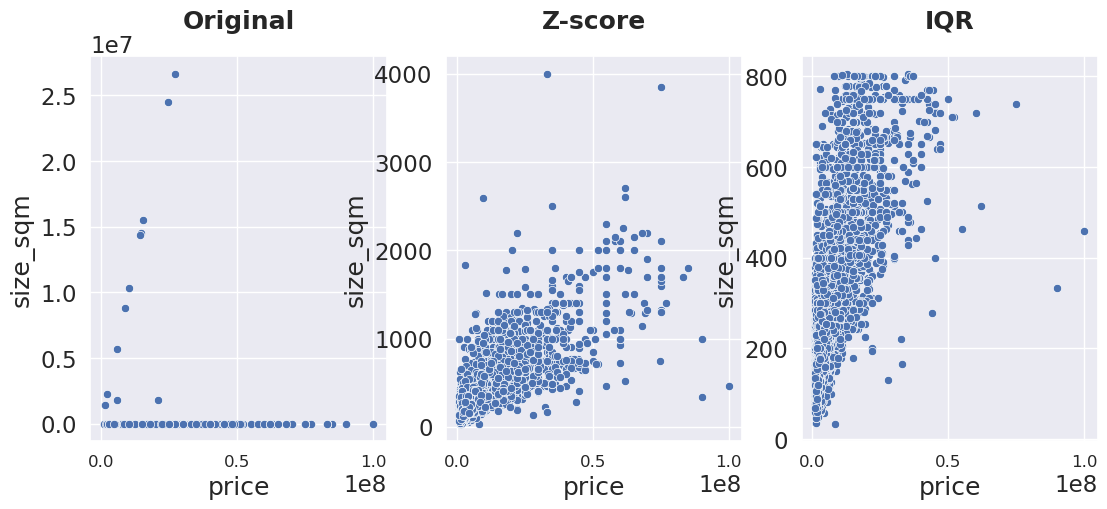

In [9]:
# Removing obvious outlier point (max) from price 
# Removing obvious outlier point (min) from size_sqm 
df_wrangled = df_wrangled[df_wrangled['price'] < df_wrangled['price'].max()]
df_wrangled = df_wrangled[df_wrangled['size_sqm'] > 1]

# Prepare new data frame 
df_wrangled_unskewed = df_wrangled.copy()

# Original statisics
print("Original number of rows:", df_wrangled_unskewed.shape[0])
print("Orignal max value:", df_wrangled_unskewed['size_sqm'].max(), "Original minimum value:", df_wrangled_unskewed['size_sqm'].min())
print("\n----------------------\n")

# Apply Z-score 
df_wrangled_unskewed_z_score = df_wrangled_unskewed[preprocessing.scale(df_wrangled_unskewed['size_sqm']) < 3]

# Apply Interquartile range 
IQR = df_wrangled_unskewed.size_sqm.quantile(0.75) - df_wrangled_unskewed.size_sqm.quantile(0.25)
size_sqm_lower_bound = df_wrangled_unskewed.size_sqm.quantile(0.25) - (IQR * 3)
size_sqm_upper_bound = df_wrangled_unskewed.size_sqm.quantile(0.75) + (IQR * 3)
df_wrangled_unskewed_IQR = df_wrangled_unskewed[(df_wrangled_unskewed["size_sqm"] >= size_sqm_lower_bound) & (df_wrangled_unskewed["size_sqm"] <= size_sqm_upper_bound)]

# Z-score statisics
print("Z-Score number of rows:", df_wrangled_unskewed_z_score.shape[0])
print(f"Skewness': {df_wrangled_unskewed_z_score['size_sqm'].skew()}")
print("Z-Score max value:", df_wrangled_unskewed_z_score['size_sqm'].max(), "Z-Score minimum value:", df_wrangled_unskewed_z_score['size_sqm'].min())
print("\n----------------------\n")


# IQR statisics
print("IQR number of rows:", df_wrangled_unskewed_IQR.shape[0])
print(f"Skewness': {df_wrangled['size_sqm'].skew()}")
print("IQR max value:", df_wrangled_unskewed_IQR['size_sqm'].max(), "IQR minimum value:", df_wrangled_unskewed_IQR['size_sqm'].min())
print("\n----------------------\n")

# Plot against price 
plt.figure(figsize=(13,5))

# Original 
plt.subplot(1,3,1)
sns.scatterplot(x="price", y="size_sqm", data=df_wrangled_unskewed)
plt.title("Original", fontweight="black", pad=20, size=18)
plt.xticks(fontsize=12)

# Z-score
plt.subplot(1,3,2)
sns.scatterplot(x="price", y="size_sqm", data=df_wrangled_unskewed_z_score)
plt.title("Z-score", fontweight="black", pad=20, size=18)
plt.xticks(fontsize=12)

# IQR 
plt.subplot(1,3,3)
sns.scatterplot(x="price", y="size_sqm", data=df_wrangled_unskewed_IQR)
plt.title("IQR", fontweight="black", pad=20, size=18)
plt.xticks(fontsize=12)
plt.show() 


Seems that z-score method both preserves the total number of columns and gives us a nearly linear correlation between "size_sqm" and "price" our target variables. subsequently we apply z_score method to remove outliers and update our data frame with new values for the next steps.

In [10]:
df_wrangled_unskewed = df_wrangled_unskewed_z_score.copy()
# Validate
df_wrangled_unskewed.describe()
# Replace nulls with 1 
df_wrangled_unskewed['bedroom'].fillna(1, inplace=True)
# Check for nulls one last time 
null_array = round(df_wrangled_unskewed.isnull().sum()/len(df_wrangled_unskewed)*100,2).sort_values().to_frame().rename(columns= {0:"Train % of Missing Values"})
print(null_array, end='\n')

             Train % of Missing Values
type                               0.0
title                              0.0
location                           0.0
bedroom                            0.0
bathroom                           0.0
size_sqm                           0.0
price                              0.0
city_parent                        0.0


# Exploratory Data Analysis

Now our data is cleaned and ready we begin some exploratory data analysis including:

* Distribution of numerical data (bedroom, size & bathroom ) - satisified in wrangling step 

* Distribution of target variable (Price) and possible transformation 

* Distribution of categorical data (type, city_parent) - we already checked distribution of numerical values

* Correlation of all numerical values (via. heatmap) 

* Visualization of numerical data (size_sqm, bederoom, bathroom) vs Target (price)

* Visualization of categorical data (city_parent, type) vs Target (price) => mean price 

### Distribution of categorical data (type, city_parent) 

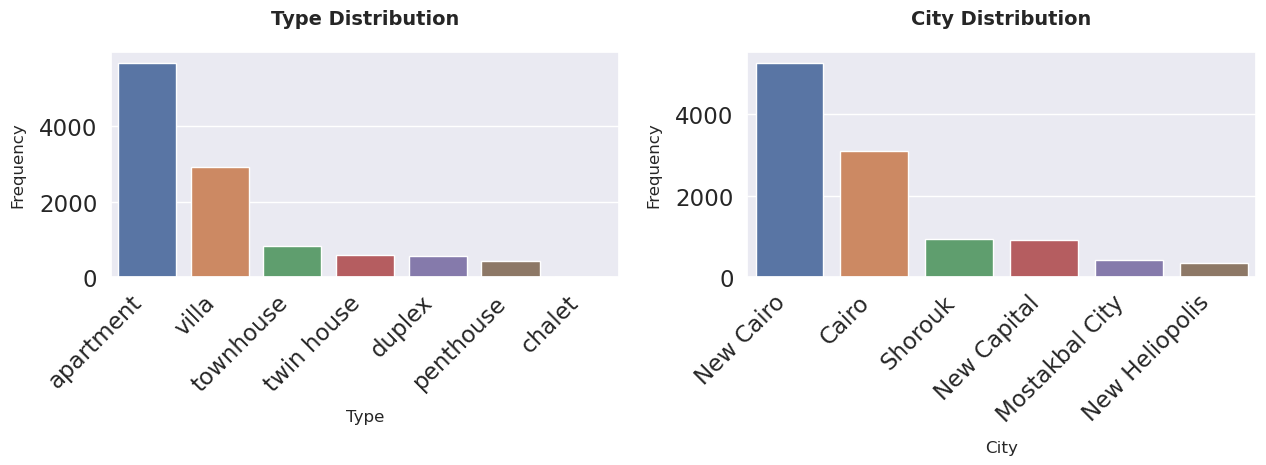

In [11]:
plt.figure(figsize=(13,5)) 
# Type distribution 
plt.subplot(1,2,1)
sns.countplot(x="type", data=df_wrangled, order=df_wrangled['type'].value_counts().index)
plt.title("Type Distribution", weight="bold", pad=20, size=14)
plt.xlabel("Type", labelpad=10, size=12)
plt.ylabel("Frequency", labelpad=10, size=12)
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

# City distribution 
plt.subplot(1,2,2)
sns.countplot(x="city_parent", data=df_wrangled, order=df_wrangled['city_parent'].value_counts().index)
plt.title("City Distribution", fontweight="bold", pad=20, size=14)
plt.xlabel("City", labelpad=10, size=12)
plt.ylabel("Frequency", labelpad=10, size=12)
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()


### Distribution of target variable (Price)
* Firstly we explore the target variable price distribution
* incase of non-normal distribution, we try figure appropriate transformation (log, johson, box-cox etc.) 

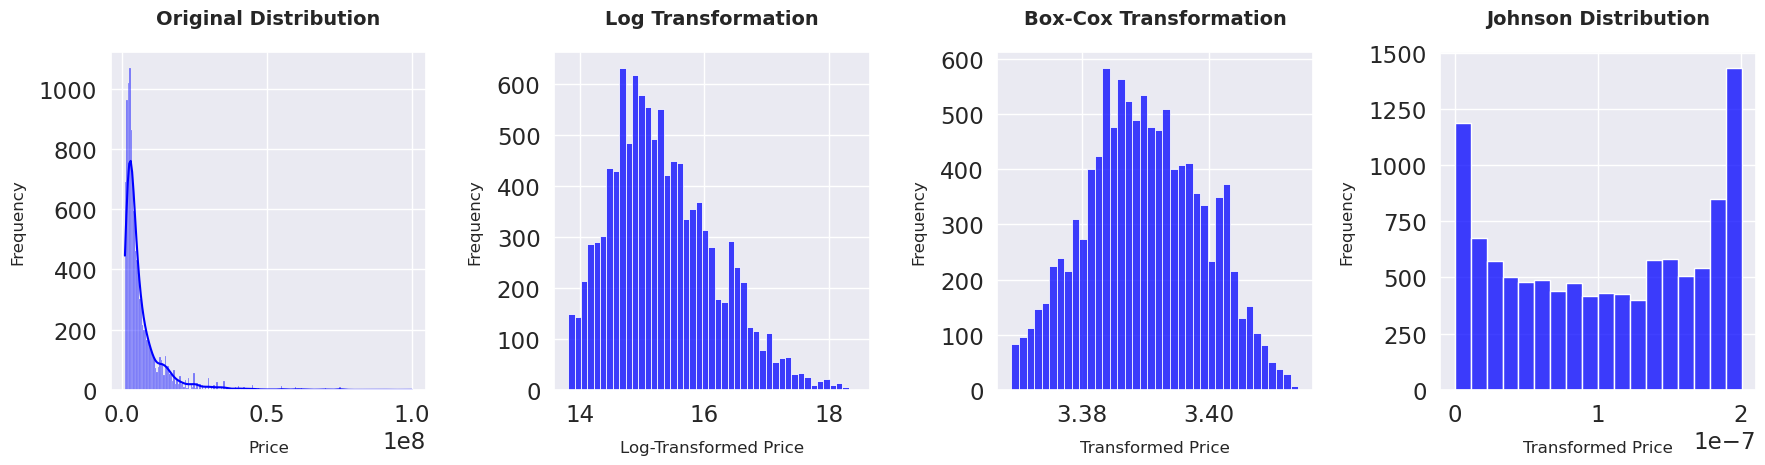

In [12]:
plt.figure(figsize=(18, 5))

# Original Price distribution
plt.subplot(1, 4, 1)
sns.histplot(df_wrangled_unskewed["price"], kde=True, color="blue")
plt.title("Original Distribution", fontweight="bold", size=14, pad=20)
plt.xlabel("Price", labelpad=10, size=12)
plt.ylabel("Frequency", labelpad=10, size=12)
plt.tight_layout()

# Log Transformation
plt.subplot(1, 4, 2)
transformed_log_price = np.log1p(df_wrangled_unskewed["price"])
sns.histplot(transformed_log_price, kde=False, color="blue")
plt.title("Log Transformation", fontweight="bold", size=14, pad=20)
plt.xlabel("Log-Transformed Price", labelpad=10, size=12)
plt.ylabel("Frequency", labelpad=10, size=12)
plt.tight_layout()

# Box-Cox Transformation
plt.subplot(1, 4, 3)
transformed_boxcox_price, lambda_value = stats.boxcox(df_wrangled_unskewed["price"])
sns.histplot(transformed_boxcox_price, kde=False, color="blue")
plt.title("Box-Cox Transformation", fontweight="bold", size=14, pad=20)
plt.xlabel("Transformed Price", labelpad=10, size=12)
plt.ylabel("Frequency", labelpad=10, size=12)
plt.tight_layout()

# Johnson Distribution
plt.subplot(1, 4, 4)
params = stats.johnsonsu.fit(df_wrangled_unskewed["price"])
transformed_johnson_price = stats.johnsonsu(*params).pdf(df_wrangled_unskewed["price"])
sns.histplot(transformed_johnson_price, kde=False, color="blue")
plt.title("Johnson Distribution", fontweight="bold", size=14, pad=20)
plt.xlabel("Transformed Price", labelpad=10, size=12)
plt.ylabel("Frequency", labelpad=10, size=12)
plt.tight_layout()

plt.show()

Box-Cox shows the most potential transforming our target to nearly perfect normal distribution, subsequently we are to use this specific transformation to transform our target variable "price" in later steps (.i.e. Feature Engineering) 

### Correlation of numeric columns (via Heatmap) 

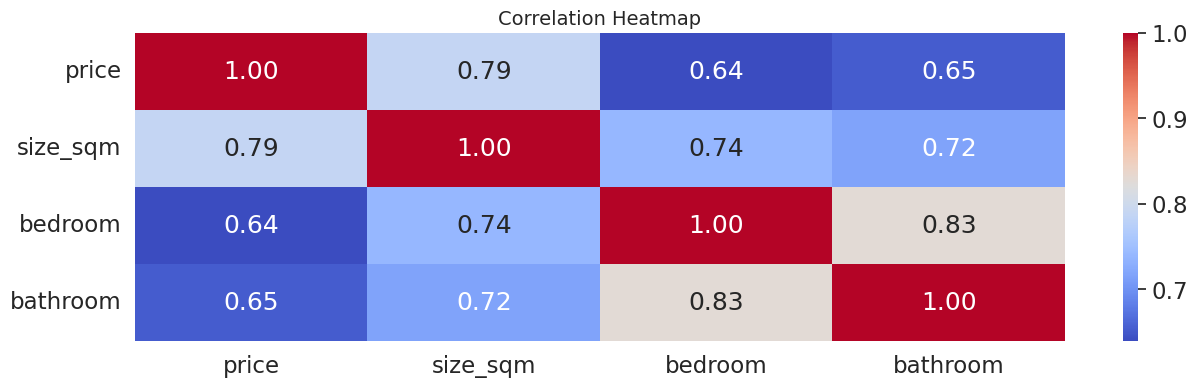

In [13]:
numerical_column = ['price', 'size_sqm', 'bedroom', 'bathroom']
correlation_matrix = df_wrangled_unskewed[numerical_column].corr()

plt.figure(figsize=(15, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

We can observe:
* moderate correlation between price and (bedroom & bathroom) 
* strong correlation between price and size (after we removed outliers) 

that means it's safe to select all three attributes for our model


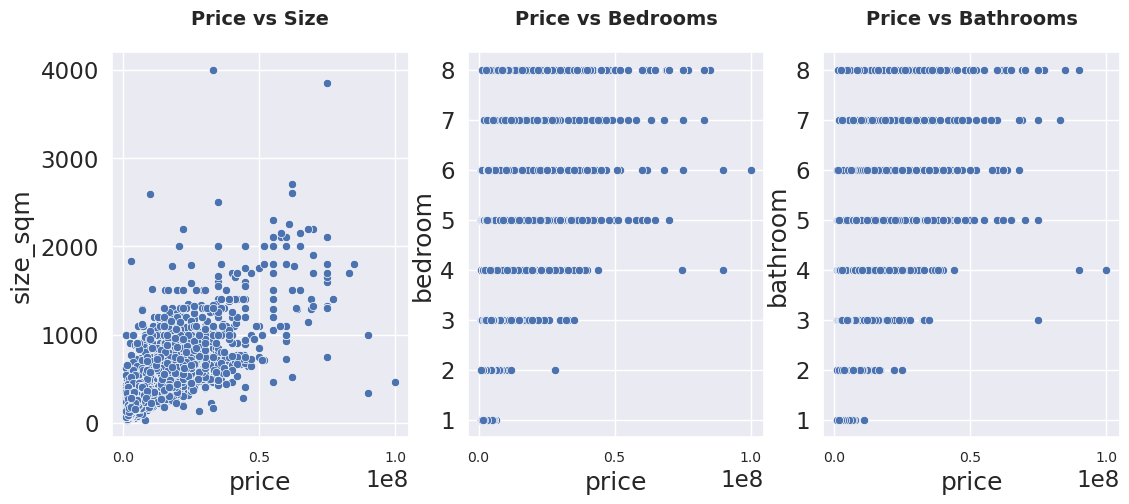

In [14]:
# Confirming correlation of bedroom & bathroom attributes with target variable price
# We do that using Z-score & plotting attributes against price at the same time
plt.figure(figsize=(13,5))

# Size 
plt.subplot(1,3,1)
sns.scatterplot( x= 'price', y= 'size_sqm', data=df_wrangled_unskewed)
plt.title("Price vs Size", fontweight="black", pad=20, size=14)
plt.xticks(fontsize=10)

# Bedroom  
plt.subplot(1,3,2)
sns.scatterplot(x='price',  y= 'bedroom', data=df_wrangled_unskewed)
plt.title("Price vs Bedrooms", fontweight="black", pad=20, size=14)
plt.xticks(fontsize=10)

# Bathroom  
plt.subplot(1,3,3)
sns.scatterplot(x='price',  y=  'bathroom', data=df_wrangled_unskewed)
plt.title("Price vs Bathrooms", fontweight="black", pad=20, size=14)
plt.xticks(fontsize=10)

plt.show()

Seems there's a potential of refining the correlation between bedroom, bathroom and price by remove some specific outliers from the visualization, so we do that and recheck our heatmap correlation, then it's safe to update our df_wrangled_unskewed dataframe

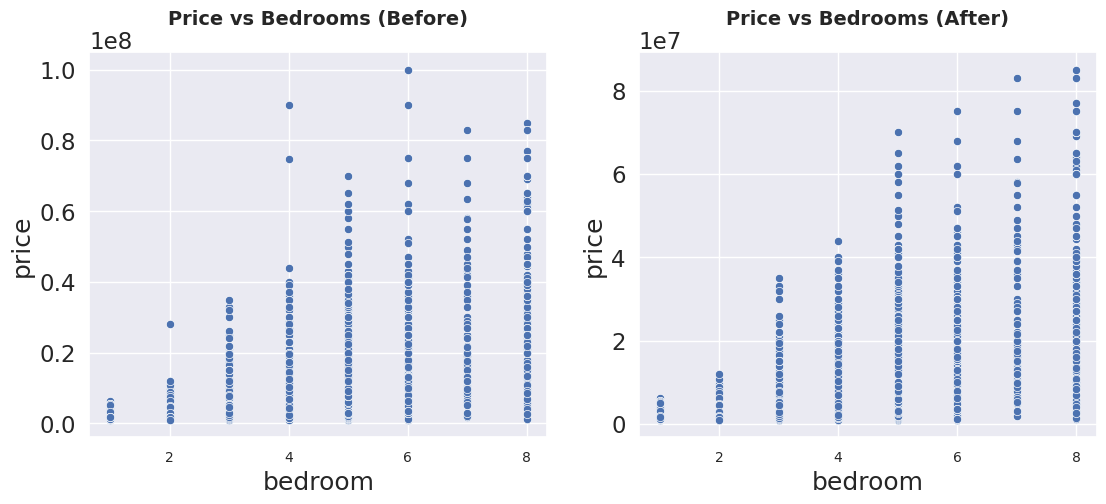

Rows before removing outliers:
10991

----------------------

Rows after removing outliers:
10986

----------------------



In [15]:
# Drop Outliers 
bedroom_outliers = (
    (df_wrangled_unskewed["bedroom"] == 2) & (df_wrangled_unskewed["price"] > 0.2 * 1e8) |
    (df_wrangled_unskewed["bedroom"] == 4) & (df_wrangled_unskewed["price"] > 0.6 * 1e8) |
    (df_wrangled_unskewed["bedroom"] == 6) & (df_wrangled_unskewed["price"] > 0.8 * 1e8)
)
df_wrangled_unskewed_new = df_wrangled_unskewed.loc[~bedroom_outliers]


plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.scatterplot(x='bedroom', y="price", data=df_wrangled_unskewed)
plt.title("Price vs Bedrooms (Before)", fontweight="black", pad=20, size=14)
plt.xticks(fontsize=10)

plt.subplot(1,2,2)
sns.scatterplot(x='bedroom' , y="price", data=df_wrangled_unskewed_new)
plt.title("Price vs Bedrooms (After)", fontweight="black", pad=20, size=14)
plt.xticks(fontsize=10)

plt.show() 

print("Rows before removing outliers:")
print(df_wrangled_unskewed.shape[0])
print("\n----------------------\n")

print("Rows after removing outliers:")
print(df_wrangled_unskewed_new.shape[0])
print("\n----------------------\n")

Repeat for bathroom

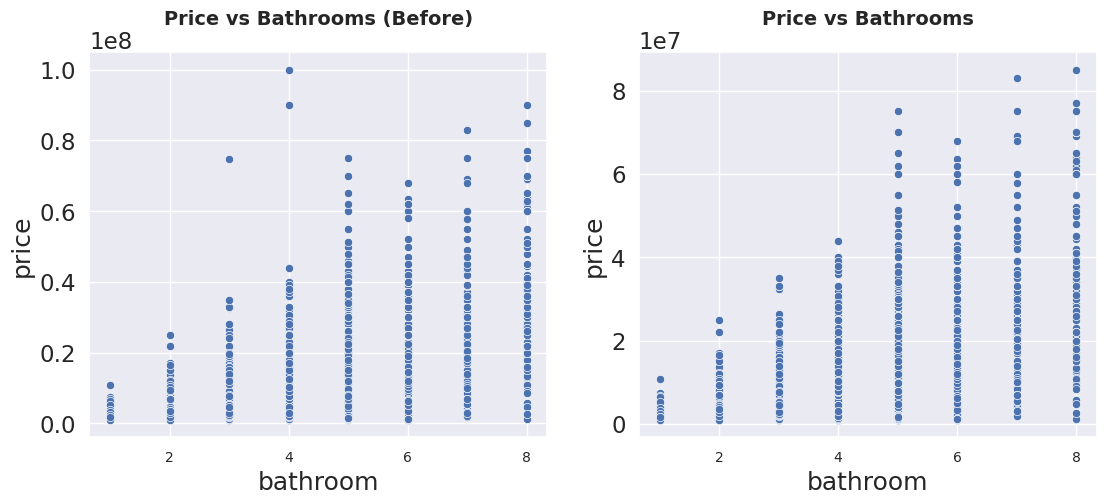

Rows after removing outliers:
10986

----------------------



In [16]:
bathroom_outliers = (
    (df_wrangled_unskewed_new["bathroom"] == 3) & (df_wrangled_unskewed_new["price"] > 0.4 * 1e8) |
    (df_wrangled_unskewed_new["bathroom"] == 4) & (df_wrangled_unskewed_new["price"] > 0.8 * 1e8) 
)
df_wrangled_unskewed_new = df_wrangled_unskewed_new.loc[~bathroom_outliers]


plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.scatterplot(x='bathroom', y="price", data=df_wrangled_unskewed)
plt.title("Price vs Bathrooms (Before)", fontweight="black", pad=20, size=14)
plt.xticks(fontsize=10)

plt.subplot(1,2,2)
sns.scatterplot(x='bathroom' , y="price", data=df_wrangled_unskewed_new)
plt.title("Price vs Bathrooms", fontweight="black", pad=20, size=14)
plt.xticks(fontsize=10)

plt.show() 

print("Rows after removing outliers:")
print(df_wrangled_unskewed_new.shape[0])
print("\n----------------------\n")

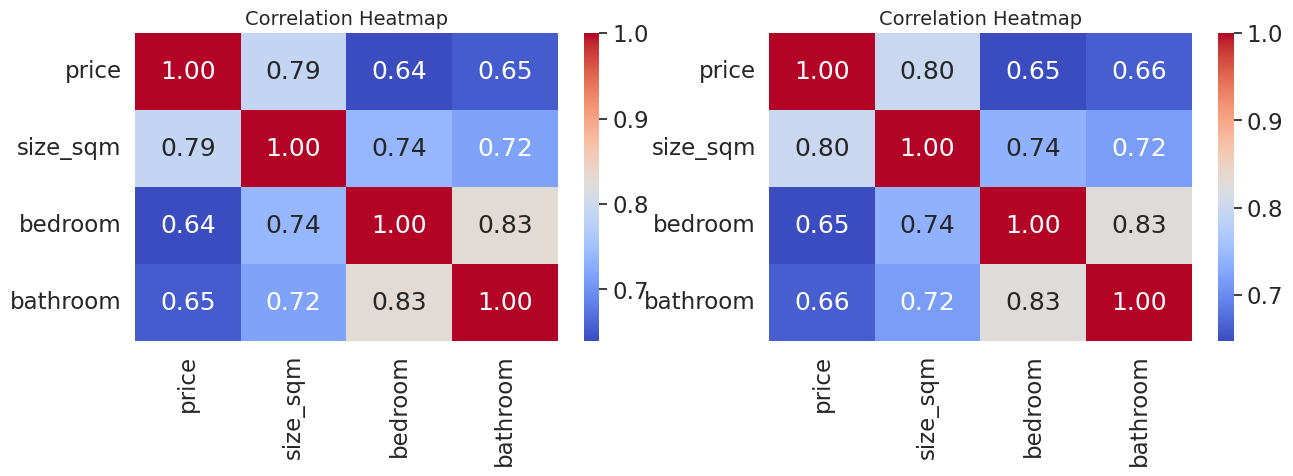

In [17]:
# Recheck correlation before and after removing outliers 
numerical_column = ['price', 'size_sqm', 'bedroom', 'bathroom']
correlation_matrix_before = df_wrangled_unskewed[numerical_column].corr()
correlation_matrix_after = df_wrangled_unskewed_new[numerical_column].corr()

plt.figure(figsize=(15, 4))

plt.subplot(1,2,1)
sns.heatmap(correlation_matrix_before, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap", fontsize=14)


plt.subplot(1,2,2)
sns.heatmap(correlation_matrix_after, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap", fontsize=14)


plt.show()

# Update our dataframe 
df_wrangled_unskewed = df_wrangled_unskewed_new.copy()

Slight rise of correlation between price & other numerical attributes 

### Correlation of categorical values with target's mean
Since we're trying to find a correlation between target (numerical) and categorical values, it's more useful to plot each category against it's mean price, then we decide if each category actually affects the price or not

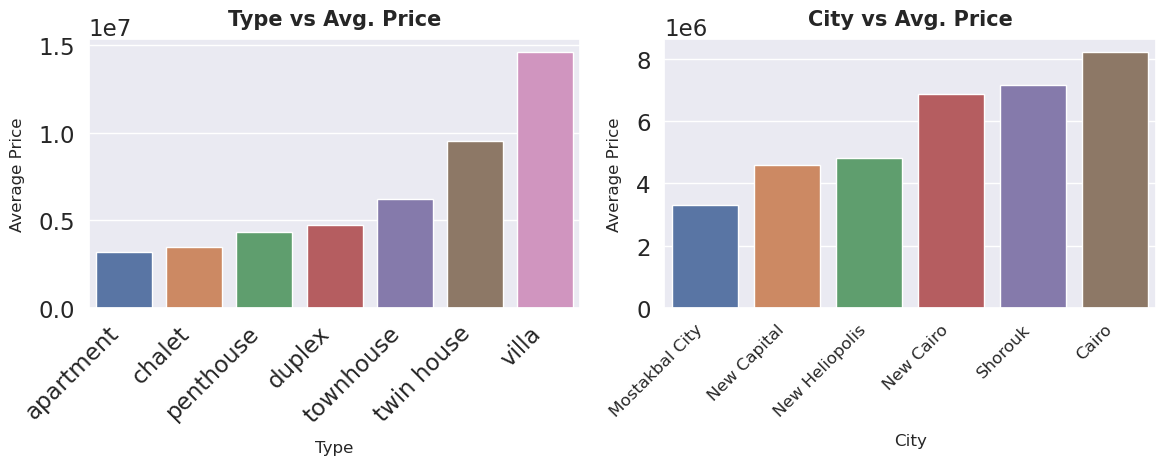

In [18]:
plt.figure(figsize=(12, 5))

# Type vs Avg. Price
plt.subplot(1, 2, 1)
type_price_mean = df_wrangled_unskewed.groupby("type")["price"].mean()
sns.barplot(x=type_price_mean.index, y=type_price_mean, order=type_price_mean.sort_values().index)
plt.title("Type vs Avg. Price", fontweight="bold", size=15, pad=10)
plt.xlabel("Type", labelpad=10, size=12)
plt.ylabel("Average Price", labelpad=10, size=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# City vs Avg. Price
plt.subplot(1, 2, 2)
city_price_mean = df_wrangled_unskewed.groupby("city_parent")["price"].mean()
sns.barplot(x=city_price_mean.index, y=city_price_mean, order=city_price_mean.sort_values().index)
plt.title("City vs Avg. Price", fontweight="bold", size=15, pad=10)
plt.xlabel("City", labelpad=10, size=12)
plt.ylabel("Average Price", labelpad=10, size=12)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.tight_layout()

plt.show()

Seems from the plots that for sure average price is affected by both the city and the type, subsequently we are to select these both features as inputs for our machine learning model.

### Correlation between bedrooms & bathrooms attributes
if strong linear correlation can be found between both, we can simply discard any of the variables in feature selection


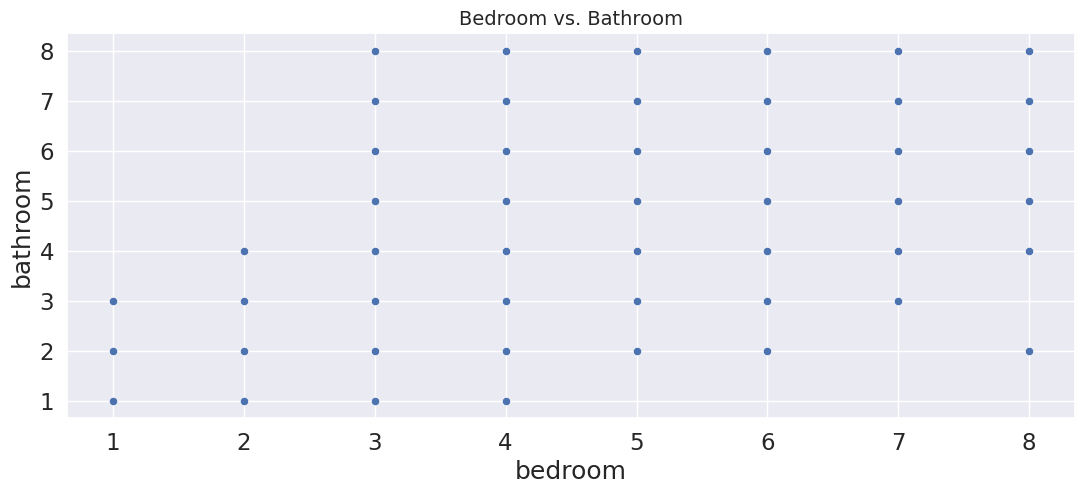

In [19]:
plt.figure(figsize=(13,5))  # Set the figure size (optional)
sns.scatterplot(x="bedroom", y="bathroom", data=df_wrangled_unskewed)
plt.title("Bedroom vs. Bathroom", fontsize=14)
plt.show()

no direct linear correlation, subsequently we're presenting both attributes to the model

Now we explored all possibilities and correlations between attributes, we move to the last step before building the model which is pre-processing some attributes to be easily digested by our model

# Feature Engineering (Pre-processing the data)

* Dropping unecessary columns (title, location) 

* Target transformation (Price) to normal distribution using Box Cox technique

* One-hot encoding for all categorical values (type & city) 

* Standerdizing numerical columns (size & price) 

### Drop unecessary columns (title, location & city) 

In [20]:
# Drop columns 
df_wrangled_unskewed_processed = df_wrangled_unskewed.drop(["title", "location"], axis=1)
# Validate
df_wrangled_unskewed_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10986 entries, 0 to 11417
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   type         10986 non-null  object 
 1   bedroom      10986 non-null  float64
 2   bathroom     10986 non-null  int64  
 3   size_sqm     10986 non-null  int64  
 4   price        10986 non-null  int64  
 5   city_parent  10986 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 600.8+ KB


### Prce transformation (using box-cox) 

In [21]:
# Get boxcox params 
price_boxcox, lambda_boxcox = stats.boxcox(df_wrangled_unskewed["price"])
# Update dataframe
df_wrangled_unskewed_processed["price"] = price_boxcox
# Validate 
for column in df_wrangled_unskewed_processed.select_dtypes(include='number'):
    print(f"Skewness for column '{column}': {df_wrangled_unskewed_processed[column].skew()}")


Skewness for column 'bedroom': 1.3124088350296914
Skewness for column 'bathroom': 1.0915856784053852
Skewness for column 'size_sqm': 4.114212098257758
Skewness for column 'price': 0.05126029388808613


### Standardizing numerical attributes (size_sqm & price) 

In [22]:
numerical_columns = ['price','size_sqm']
# Initiate standard scaler
scaler = StandardScaler()
# Apply the scaling to the numerical columns
df_wrangled_unskewed_processed[numerical_columns] = scaler.fit_transform(df_wrangled_unskewed_processed[numerical_columns])
# Validate 
print(df_wrangled_unskewed_processed.describe())

            bedroom      bathroom      size_sqm         price
count  10986.000000  10986.000000  1.098600e+04  1.098600e+04
mean       3.440379      3.320681  5.174169e-17 -2.558109e-14
std        1.179612      1.308397  1.000046e+00  1.000046e+00
min        1.000000      1.000000 -1.073446e+00 -2.257099e+00
25%        3.000000      2.000000 -5.352781e-01 -7.076178e-01
50%        3.000000      3.000000 -3.093296e-01 -4.284619e-02
75%        4.000000      4.000000  1.220267e-01  7.503705e-01
max        8.000000      8.000000  1.521950e+01  2.554137e+00


### One- Hot Encoding
* First check for cardinality to decide on encoding technique (one hot encoding: low cardinality, target encoding: high cardinality) 

In [23]:
# Apply one hot encoding to both type & city attributes 
df_wrangled_unskewed_processed = pd.get_dummies(df_wrangled_unskewed_processed, columns=['type'], prefix='type')
df_wrangled_unskewed_processed = pd.get_dummies(df_wrangled_unskewed_processed, columns=['city_parent'], prefix='city')
# Validate
df_wrangled_unskewed_processed.head(20)

,bedroom,bathroom,size_sqm,price,type_apartment,type_chalet,type_duplex,type_penthouse,type_townhouse,type_twin house,type_villa,city_Cairo,city_Mostakbal City,city_New Cairo,city_New Capital,city_New Heliopolis,city_Shorouk
0,4.0,4,0.204190,0.583044,0,0,1,0,0,0,0,1,0,0,0,0,0
1,3.0,3,-0.042299,0.978151,0,0,0,0,0,0,1,0,0,1,0,0,0
2,3.0,3,-0.350411,0.374913,1,0,0,0,0,0,0,0,0,1,0,0,0
3,4.0,4,-0.268248,0.683129,0,0,0,0,1,0,0,0,0,0,1,0,0
4,5.0,6,-0.046408,0.815095,0,0,0,1,0,0,0,0,0,1,0,0,0
5,3.0,2,-0.506521,-0.377552,1,0,0,0,0,0,0,0,0,1,0,0,0
6,5.0,4,-0.186085,-0.234258,0,0,0,0,0,0,1,0,0,1,0,0,0
7,4.0,4,-0.309330,0.453014,0,0,0,0,1,0,0,0,0,1,0,0,0
8,2.0,2,-0.744794,-0.846452,1,0,0,0,0,0,0,0,0,1,0,0,0
9,3.0,3,-0.375060,-0.023165,1,0,0,0,0,0,0,0,0,1,0,0,0


# The Model

at this point we have the data prepared and ready, we train different models on the data and compare performance using mean squared error (MSE) and r-squared (R2) for each, models we'll use is:
* Linear Regression
* Decision Trees
* Random Forests 

### Selecting the right model

In [24]:
# Function to evaluate a machine learning model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'Model': model_name, 'MSE': mse, 'R-squared': r2}

# Separate features (inputs) and target
X = df_wrangled_unskewed_processed.drop(columns=['price'])
y = df_wrangled_unskewed_processed['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a dictionary to store the results of different models
results = {}

# Linear Regression
linear_reg = LinearRegression()
results['Linear Regression'] = evaluate_model(linear_reg, X_train, X_test, y_train, y_test)

# Decision Tree Regressor
decision_tree = DecisionTreeRegressor(random_state=42)
results['Decision Tree'] = evaluate_model(decision_tree, X_train, X_test, y_train, y_test)

# Random Forest Regressor
random_forest = RandomForestRegressor(random_state=42)
results['Random Forest'] = evaluate_model(random_forest, X_train, X_test, y_train, y_test)

# Display the results
for model_name, model_results in results.items():
    print(model_name)
    print("Mean Squared Error:", model_results['MSE'])
    print("R-squared:", model_results['R-squared'])
    print()

# You can also save the results to a DataFrame if you want to compare them visually
results_df = pd.DataFrame(results)
print(results_df)

Linear Regression
Mean Squared Error: 0.4056335676051514
R-squared: 0.5870146092032623

Decision Tree
Mean Squared Error: 0.45442331920789386
R-squared: 0.5373405776592357

Random Forest
Mean Squared Error: 0.35804953655569716
R-squared: 0.6354610673567749

          Linear Regression          Decision Tree          Random Forest
Model      LinearRegression  DecisionTreeRegressor  RandomForestRegressor
MSE                0.405634               0.454423                0.35805
R-squared          0.587015               0.537341               0.635461


It appears that **random forest** technique outperformed **linear regression and decision trees** having less MSE & greated R-square, subsequently it can be selected as our predictor for house prices, however there might be room for improving the algorithm using **hyper parameter tunning**.

### Hyper parameter Tuning 

In [25]:
# Define the hyperparameter space
param_grid = {
    'n_estimators': [50, 100, 200],        # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],       # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]          # Minimum samples required to be at a leaf node
}

# Create the Random Forest regressor
rf = RandomForestRegressor(random_state=42)

# Create GridSearchCV object with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_tuned = best_rf.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared (R2) for tuned model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\nAfter Tuning - Mean Squared Error:", mse_tuned)
print("After Tuning - R-squared:", r2_tuned)


After Tuning - Mean Squared Error: 0.3390639912423472
After Tuning - R-squared: 0.6547907123292425


Hyper paramter tunning didn't seem to have a noticable impact on the accuracy. 

# Conclusion

To conclude, we pick our tuned random forest as our predictor model; however since accuracy is relativly low (65 %) only, there's still room for improvment in the future:
* Feature combination (combining different features .e.g. size * location) 
* Ensembles (coupling ensemble model with other models .e.g. regression)
* Different input combination (.e.g. maybe try train the models with & without outliers) 
* If possible, collect more data 

# Thank you
## Email: er.kareem.tarek@gmail.com